In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import sys
sys.version_info

sys.version_info(major=3, minor=9, micro=12, releaselevel='final', serial=0)

In [3]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Dropout
from sklearn.metrics import accuracy_score
np.random.seed(42)

In [5]:
import keras_tuner as kt

from matplotlib import style
style.use('fivethirtyeight')

## Loading the Data:

In [6]:
data_dir = (r'C:\Users\kushw\Independent study Project')
train_path = (r'C:\Users\kushw\Independent study Project\Train')
test_path = (r'C:\Users\kushw\Independent study Project\Test')

## Resizing the Images:

In [7]:
# Resizing the images to 30x30x3
IMG_HEIGHT = 50
IMG_WIDTH = 50
channels = 3

In [8]:
NUM_CATEGORIES = len(os.listdir(train_path))
print("this is the number of sign class")
NUM_CATEGORIES

this is the number of sign class


43

In [9]:
# Label Overview finded on internet
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

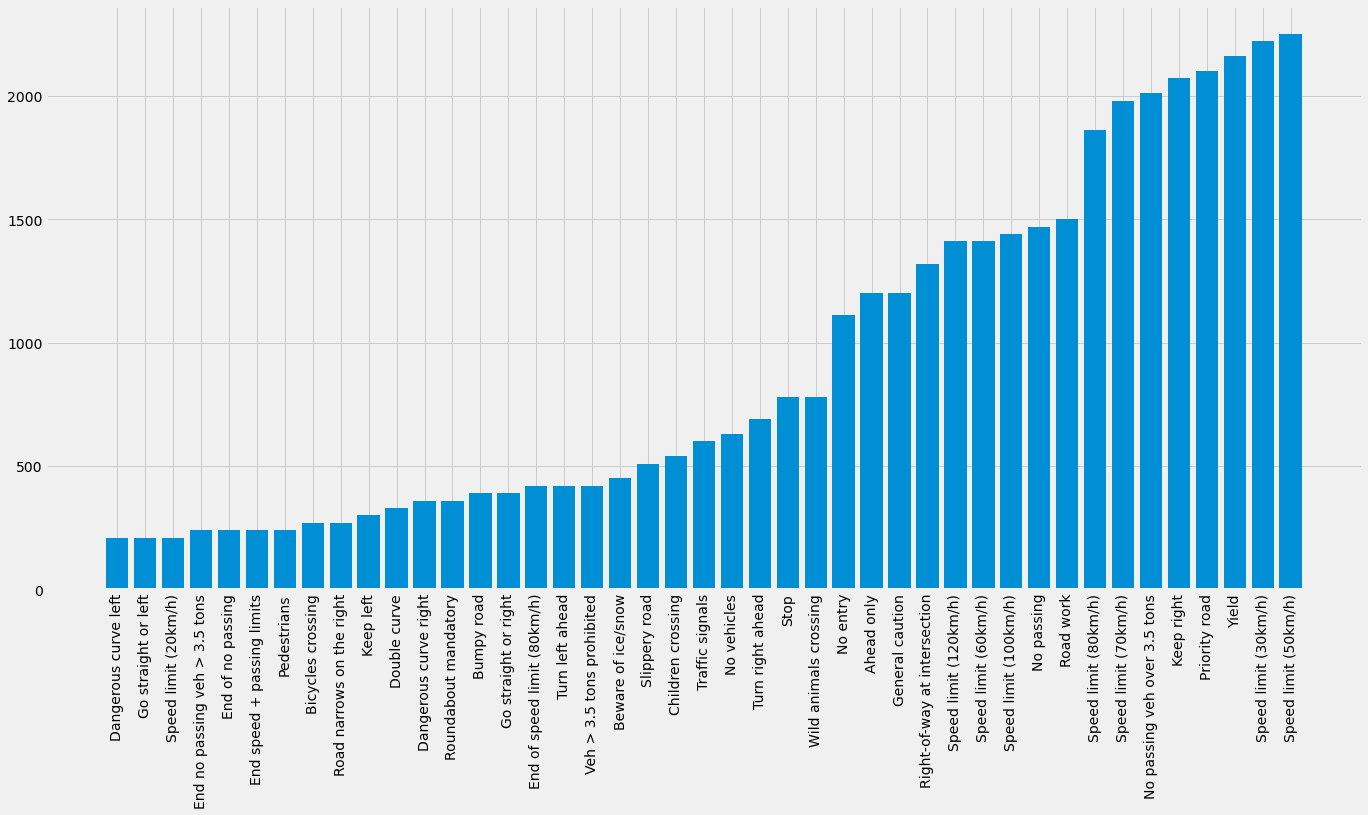

In [10]:
#we see the distribution of our classes in the training set
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

C:\Users\kushw\AppData\Local\Temp\ipykernel_21928\3622557811.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


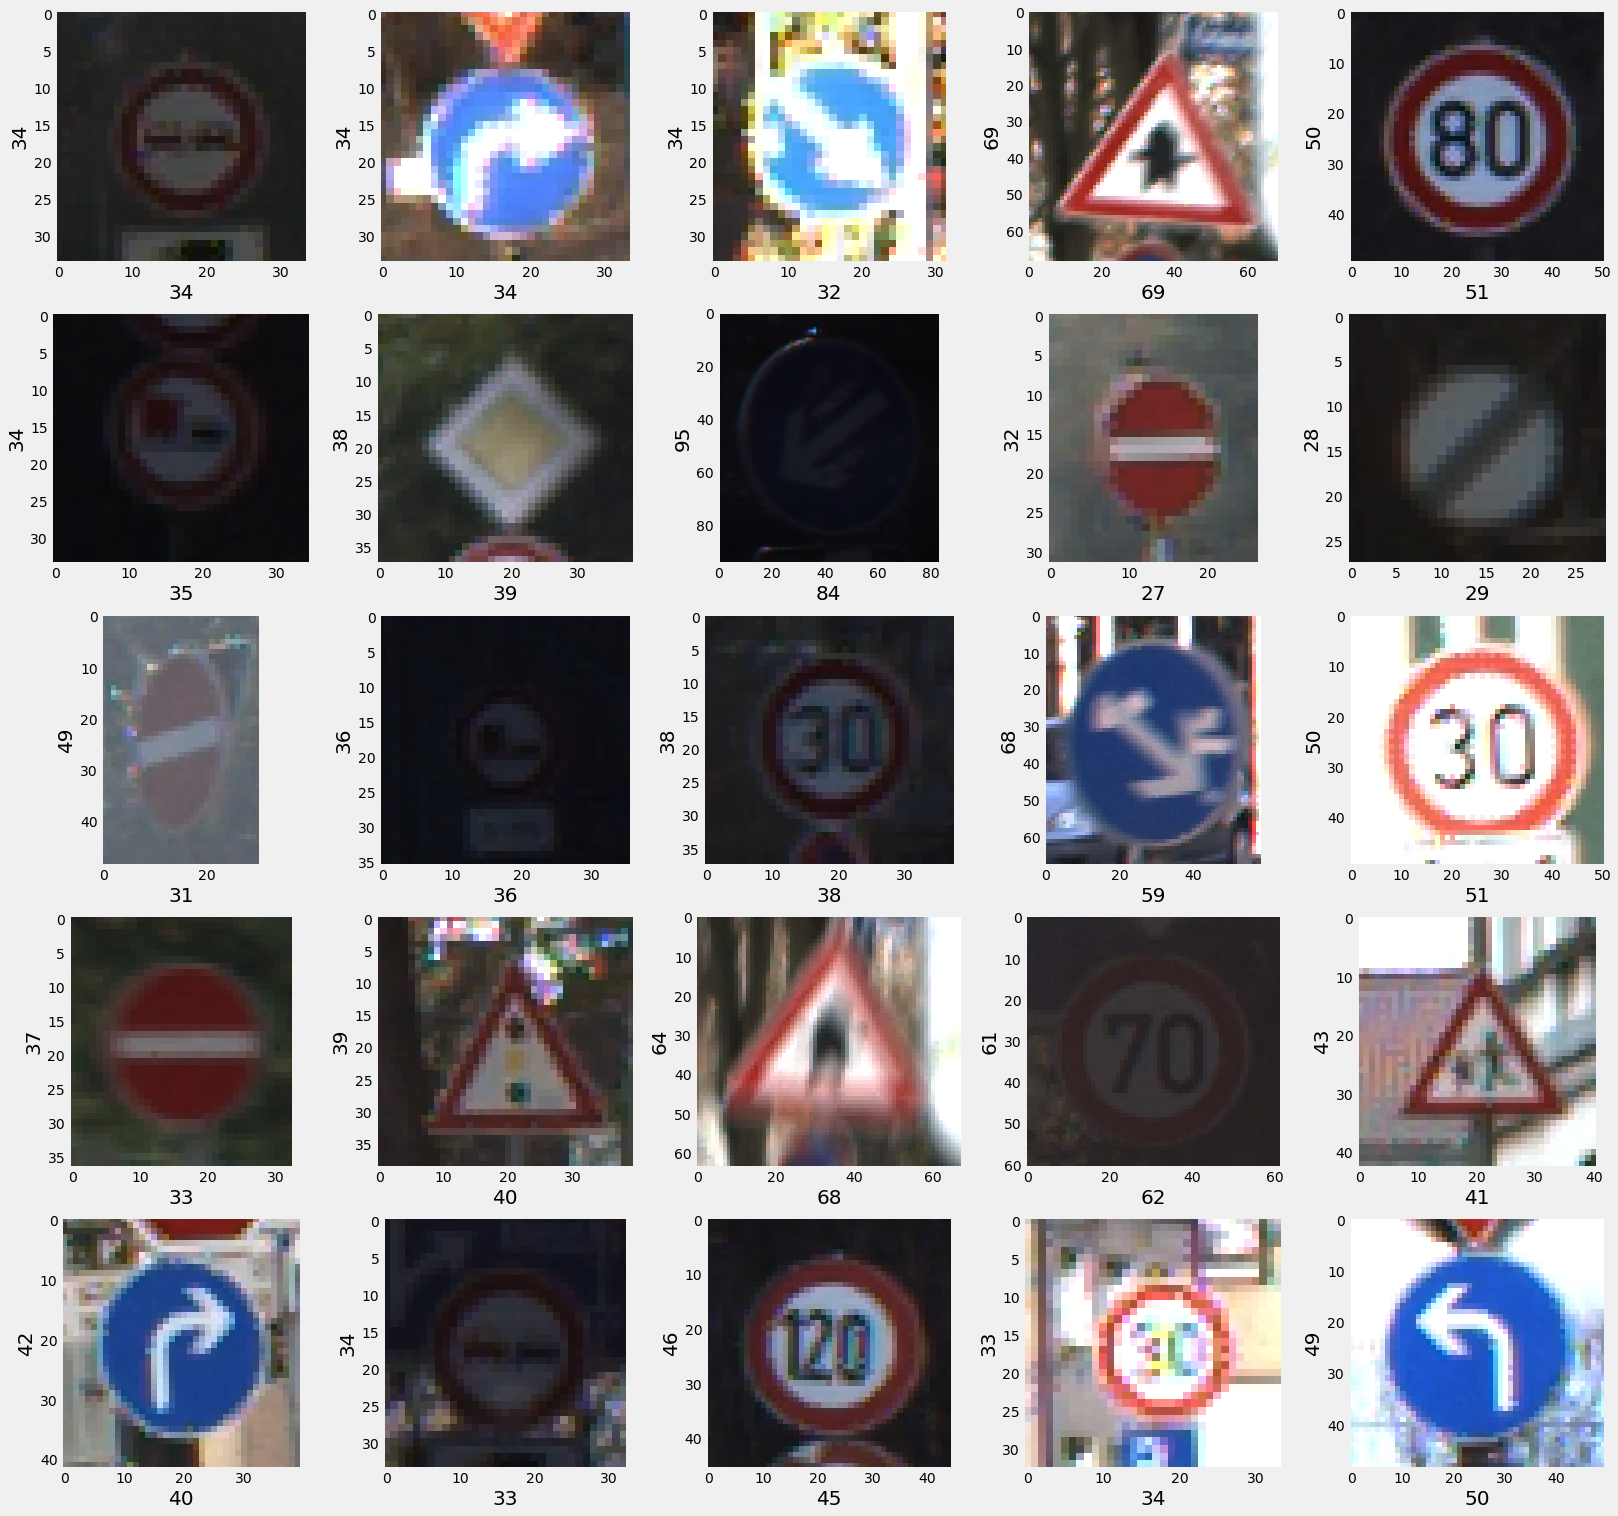

In [11]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv( 'Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path =  random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [12]:
#we put all image with classes in np array
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)
print("Done")

Done


In [13]:
# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 50, 50, 3) (39209,)


In [14]:
#we mix the array, so when we go to create train, test and validation, we avoid having a predominance of classes
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [15]:
#we split the train and test set , 80 - 20 
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (31367, 50, 50, 3)
X_valid.shape (7842, 50, 50, 3)
y_train.shape (31367,)
y_valid.shape (7842,)


In [16]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.unique(y_train),
                                                  y = y_train)

# the field class weight in model.fit() is a dictionary, so we convert class_weights into a dictionary
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [17]:
#is maded the one hot encoding to train the keras model
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(31367, 43)
(7842, 43)


In [18]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

## CNN

In [19]:
from tensorflow import keras
from tensorflow.keras import layers
#we made the model with the augmentation layer

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', input_shape = [50, 50,3]))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=64 , activation='relu',kernel_size=3))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=128 , activation='relu' ,kernel_size=3))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(250,activation='relu'))
model.add(keras.layers.Dense(43,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [20]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy']
              )

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=15, validation_data=(X_val, y_val) , verbose = 1 , callbacks=[early_stopping], class_weight = class_weights)

Epoch 1/15
981/981 [==============================] - 137s 137ms/step - loss: 2.1613 - accuracy: 0.3707 - val_loss: 0.8127 - val_accuracy: 0.7071
Epoch 2/15
981/981 [==============================] - 55s 56ms/step - loss: 0.8359 - accuracy: 0.7183 - val_loss: 0.2921 - val_accuracy: 0.9111
Epoch 3/15
981/981 [==============================] - 63s 64ms/step - loss: 0.4951 - accuracy: 0.8266 - val_loss: 0.1132 - val_accuracy: 0.9739
Epoch 4/15
981/981 [==============================] - 65s 66ms/step - loss: 0.3843 - accuracy: 0.8750 - val_loss: 0.1287 - val_accuracy: 0.9736
Epoch 5/15
981/981 [==============================] - 67s 68ms/step - loss: 0.3106 - accuracy: 0.8971 - val_loss: 0.0602 - val_accuracy: 0.9852
Epoch 6/15
981/981 [==============================] - 66s 67ms/step - loss: 0.2811 - accuracy: 0.9102 - val_loss: 0.0708 - val_accuracy: 0.9819
Epoch 7/15
981/981 [==============================] - 69s 70ms/step - loss: 0.2671 - accuracy: 0.9167 - val_loss: 0.0416 - val_accurac

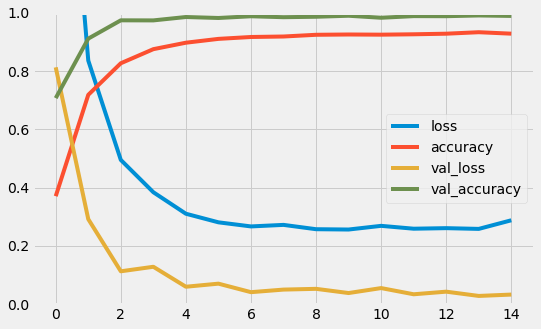

In [21]:
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [22]:

#test with the test set taken from file
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

# pred = model.predict_classes(X_test)

predict_x=model.predict(X_test) 
pred=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 10s 22ms/step
Test Data accuracy:  96.64291369754552


<AxesSubplot:>

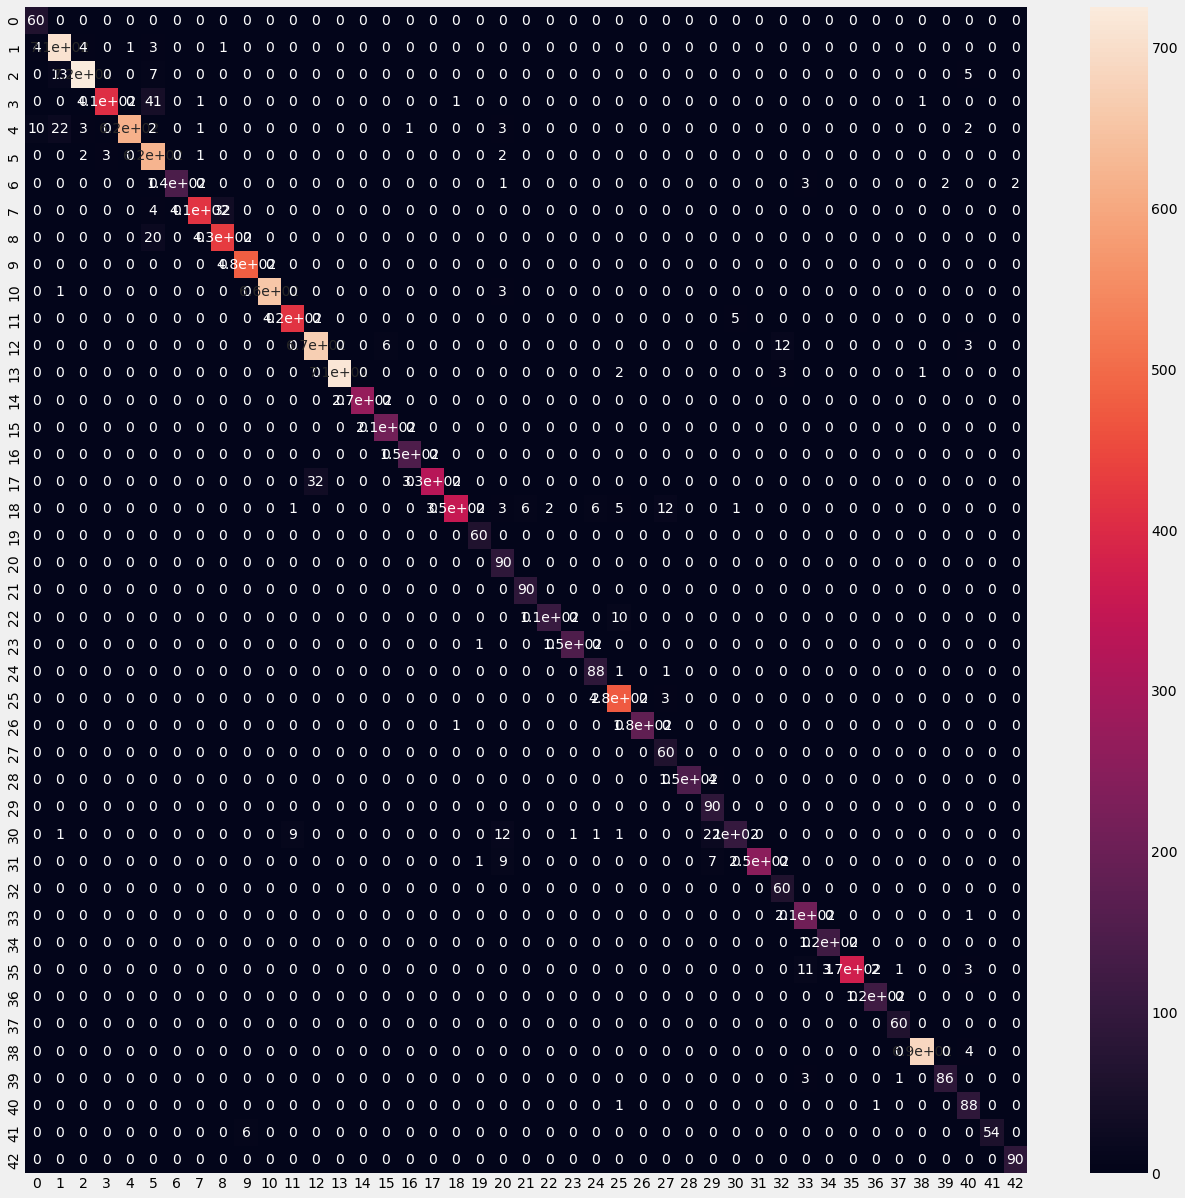

In [23]:
#visualize confusion matrix of classifier
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [24]:
#classification report of our model 
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90        60
           1       0.95      0.98      0.97       720
           2       0.99      0.97      0.98       750
           3       0.99      0.90      0.95       450
           4       1.00      0.93      0.96       660
           5       0.89      0.99      0.94       630
           6       1.00      0.95      0.97       150
           7       0.99      0.92      0.96       450
           8       0.93      0.96      0.94       450
           9       0.99      1.00      0.99       480
          10       1.00      0.99      1.00       660
          11       0.98      0.99      0.98       420
          12       0.95      0.97      0.96       690
          13       1.00      0.99      1.00       720
          14       1.00      1.00      1.00       270
          15       0.97      1.00      0.99       210
          16       0.99      1.00      1.00       150
          17       1.00    

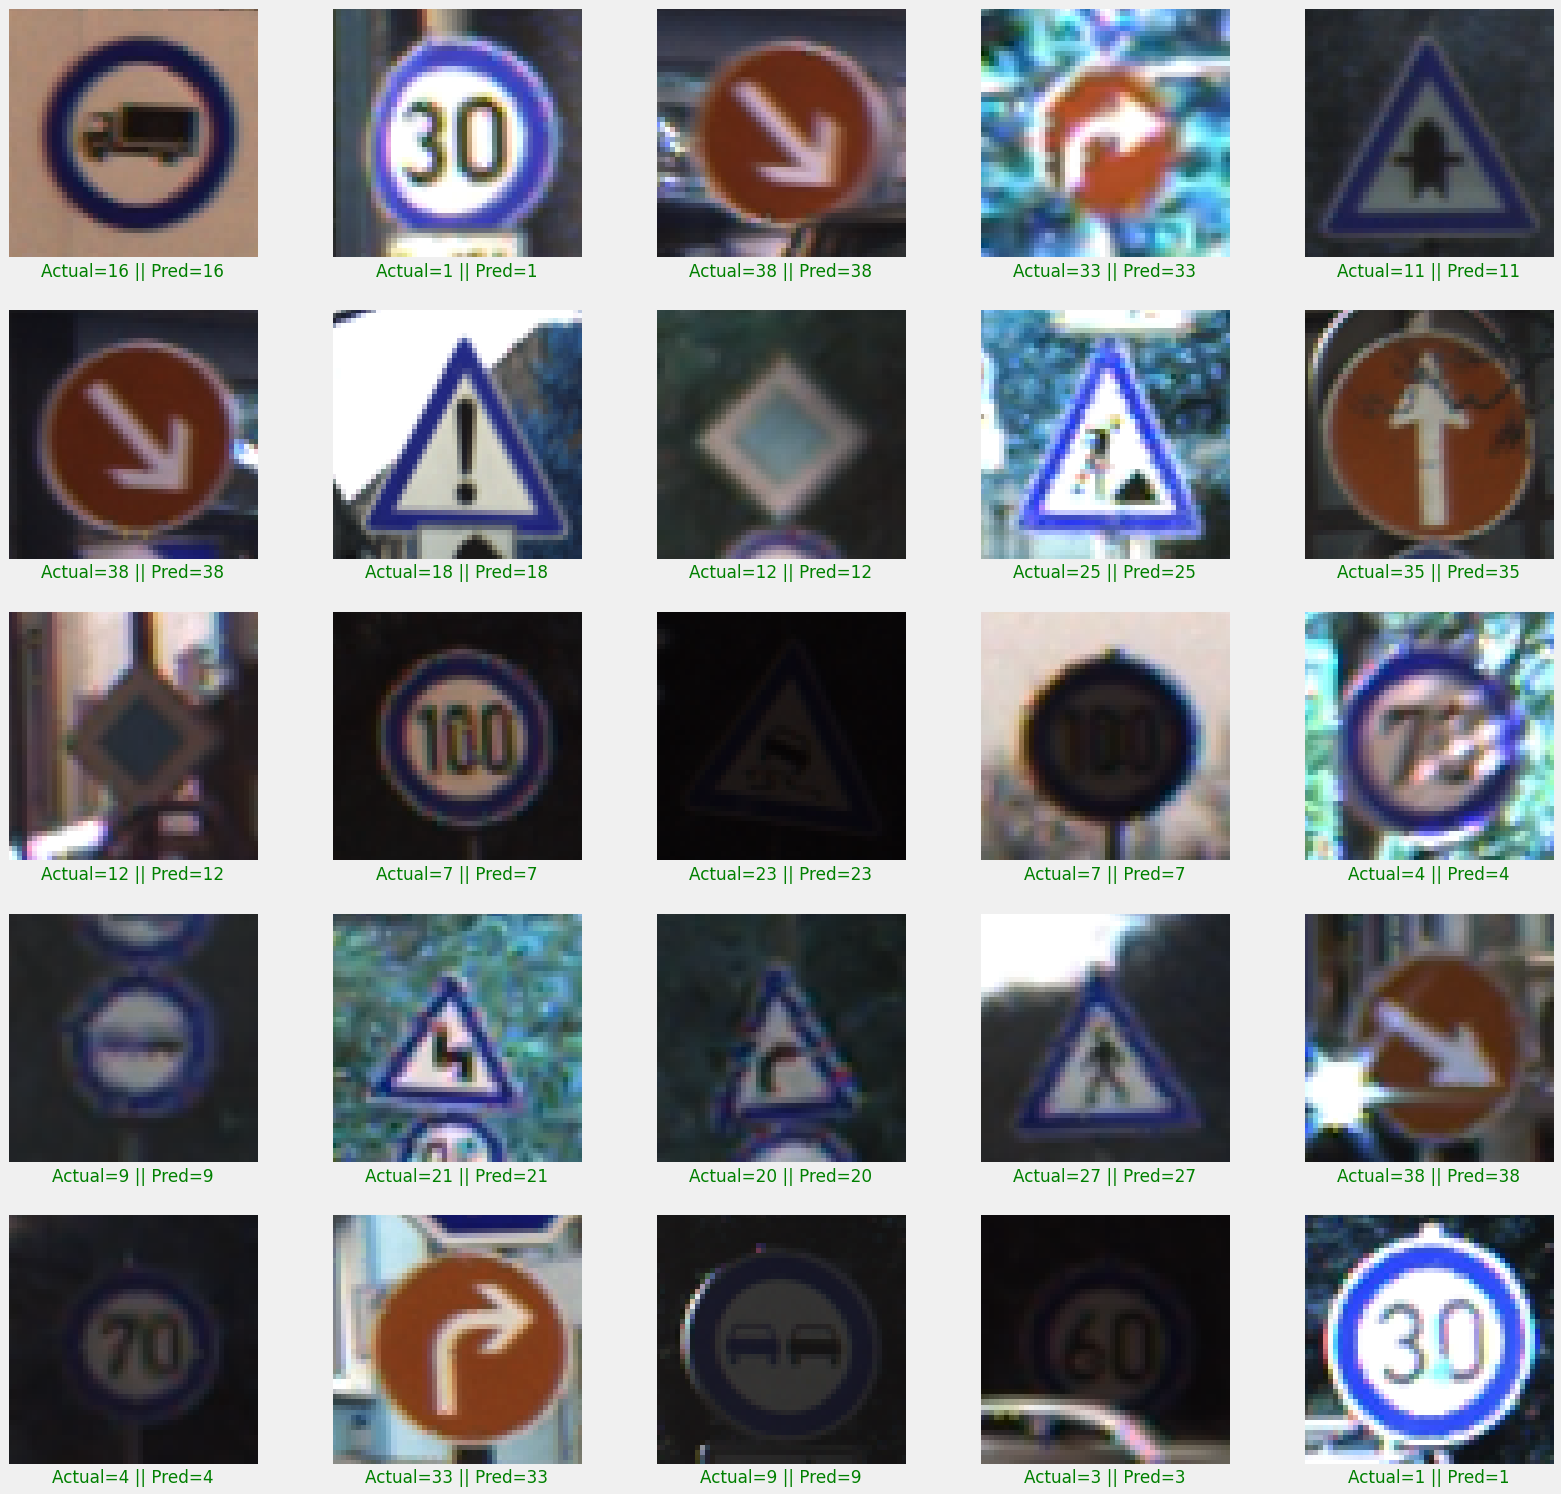

In [25]:
# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Set figure size for visualizations
plt.figure(figsize=(25, 25))

# Define starting index for displaying images
start_index = 0

# Loop through 25 images to display
for i in range(25):
    # Create a subplot for each image
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    # Get the predicted and actual labels for the current image
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    
    # Set the color of the label based on whether the prediction is correct or not
    col = 'g'
    if prediction != actual:
        col = 'r'
    
    # Display the image and the label
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color=col)
    plt.imshow(X_test[start_index + i])

# Display the plotted images
plt.show()



### Hyper Tuning

In [26]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', input_shape = [50, 50,3]))
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(keras.layers.Conv2D(filters=64 , activation='relu',kernel_size=3))
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(keras.layers.Conv2D(filters=128 , activation='relu' ,kernel_size=3))
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.5))
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units,activation='sigmoid'))
  model.add(keras.layers.Dense(43,activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

  return model

In [27]:
import datetime
# Create permanent folder in Google Drive
my_dir = r'C:\Users\kushw\Independent study Project'
if not os.path.exists(my_dir):
  os.makedirs(my_dir)
log_dir = my_dir + "/logs/" + datetime.datetime.now().strftime("%m%d-%H%M")

In [28]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     overwrite=True,
                     max_epochs=20,
                     factor=3,
                     directory=log_dir,
                     project_name='kerasTuner_mnist')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tensorboard = keras.callbacks.TensorBoard(log_dir)
tuner.search(X_train, y_train, epochs=5, validation_split=0.2, callbacks=[stop_early, tensorboard])

Trial 30 Complete [00h 09m 01s]
val_accuracy: 0.05929231643676758

Best val_accuracy So Far: 0.9968122243881226
Total elapsed time: 03h 29m 46s
INFO:tensorflow:Oracle triggered exit


##  optimal hyperparameters

In [29]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The hyperparameter search is complete. \
        The optimal number of units in the first densely-connected layer is {best_hps.get('units')} and \
        the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")

The hyperparameter search is complete.         The optimal number of units in the first densely-connected layer is 224 and         the optimal learning rate for the optimizer is 0.001.


In [30]:
import tensorboard
%load_ext tensorboard
%tensorboard --logdir "$log_dir"
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=5, validation_data=(X_val, y_val) , verbose = 1 ,callbacks=[early_stopping])


val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/5
981/981 [==============================] - 78s 78ms/step - loss: 1.8575 - accuracy: 0.4444 - val_loss: 0.7024 - val_accuracy: 0.7756
Epoch 2/5
981/981 [==============================] - 76s 77ms/step - loss: 0.7672 - accuracy: 0.7516 - val_loss: 0.2183 - val_accuracy: 0.9398
Epoch 3/5
981/981 [==============================] - 75s 76ms/step - loss: 0.4332 - accuracy: 0.8640 - val_loss: 0.0697 - val_accuracy: 0.9842
Epoch 4/5
981/981 [==============================] - 81s 82ms/step - loss: 0.2970 - accuracy: 0.9045 - val_loss: 0.0603 - val_accuracy: 0.9843
Epoch 5/5
981/981 [==============================] - 77s 79ms/step - loss: 0.2224 - accuracy: 0.9303 - val_loss: 0.0340 - val_accuracy: 0.9901
Best epoch: 5


In [31]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(aug.flow(X_train, y_train, batch_size=32), epochs=best_epoch,  validation_data=(X_val, y_val) , verbose = 1 , callbacks=[early_stopping])

Epoch 1/5
981/981 [==============================] - 79s 79ms/step - loss: 1.8204 - accuracy: 0.4629 - val_loss: 0.5899 - val_accuracy: 0.8421
Epoch 2/5
981/981 [==============================] - 85s 86ms/step - loss: 0.6781 - accuracy: 0.7862 - val_loss: 0.1988 - val_accuracy: 0.9440
Epoch 3/5
981/981 [==============================] - 75s 77ms/step - loss: 0.3889 - accuracy: 0.8770 - val_loss: 0.0613 - val_accuracy: 0.9858
Epoch 4/5
981/981 [==============================] - 76s 78ms/step - loss: 0.2692 - accuracy: 0.9154 - val_loss: 0.0659 - val_accuracy: 0.9816
Epoch 5/5
981/981 [==============================] - 78s 79ms/step - loss: 0.2084 - accuracy: 0.9344 - val_loss: 0.0291 - val_accuracy: 0.9923


In [32]:
model.save('traffic_classifier.h5')   # always save your weights after training or during training

In [33]:
hypermodel.save('traffic_classifier.h5')   # always save your weights after training or during training

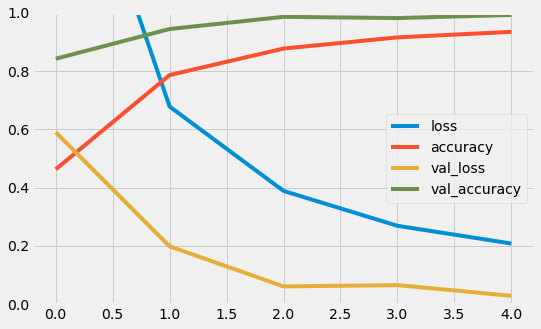

In [34]:
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [35]:
#test with the test set taken from file
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

# pred = model.predict_classes(X_test)
predict_x=model.predict(X_test) 
pred=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 9s 22ms/step
Test Data accuracy:  96.35787806809184


<AxesSubplot:>

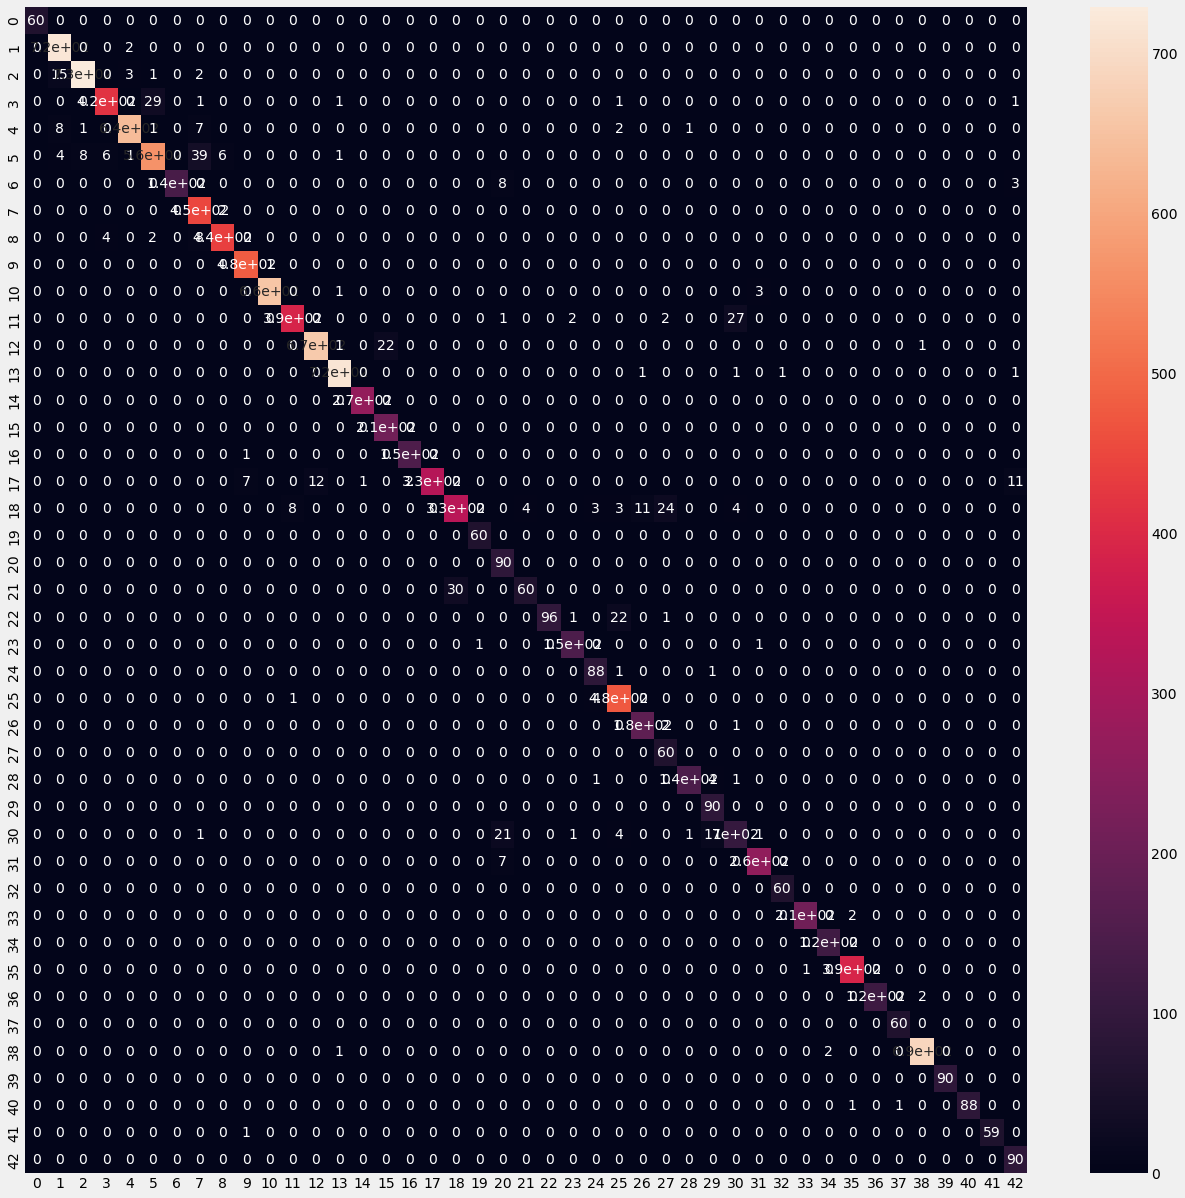

In [36]:
#visualize confusion matrix of classifier
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [37]:
#classification report of our model 
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.96      1.00      0.98       720
           2       0.99      0.97      0.98       750
           3       0.98      0.93      0.95       450
           4       0.99      0.97      0.98       660
           5       0.94      0.90      0.92       630
           6       1.00      0.93      0.96       150
           7       0.89      1.00      0.94       450
           8       0.98      0.97      0.98       450
           9       0.98      1.00      0.99       480
          10       1.00      0.99      1.00       660
          11       0.98      0.92      0.95       420
          12       0.98      0.97      0.97       690
          13       0.99      0.99      0.99       720
          14       1.00      1.00      1.00       270
          15       0.91      1.00      0.95       210
          16       0.99      0.99      0.99       150
          17       1.00    

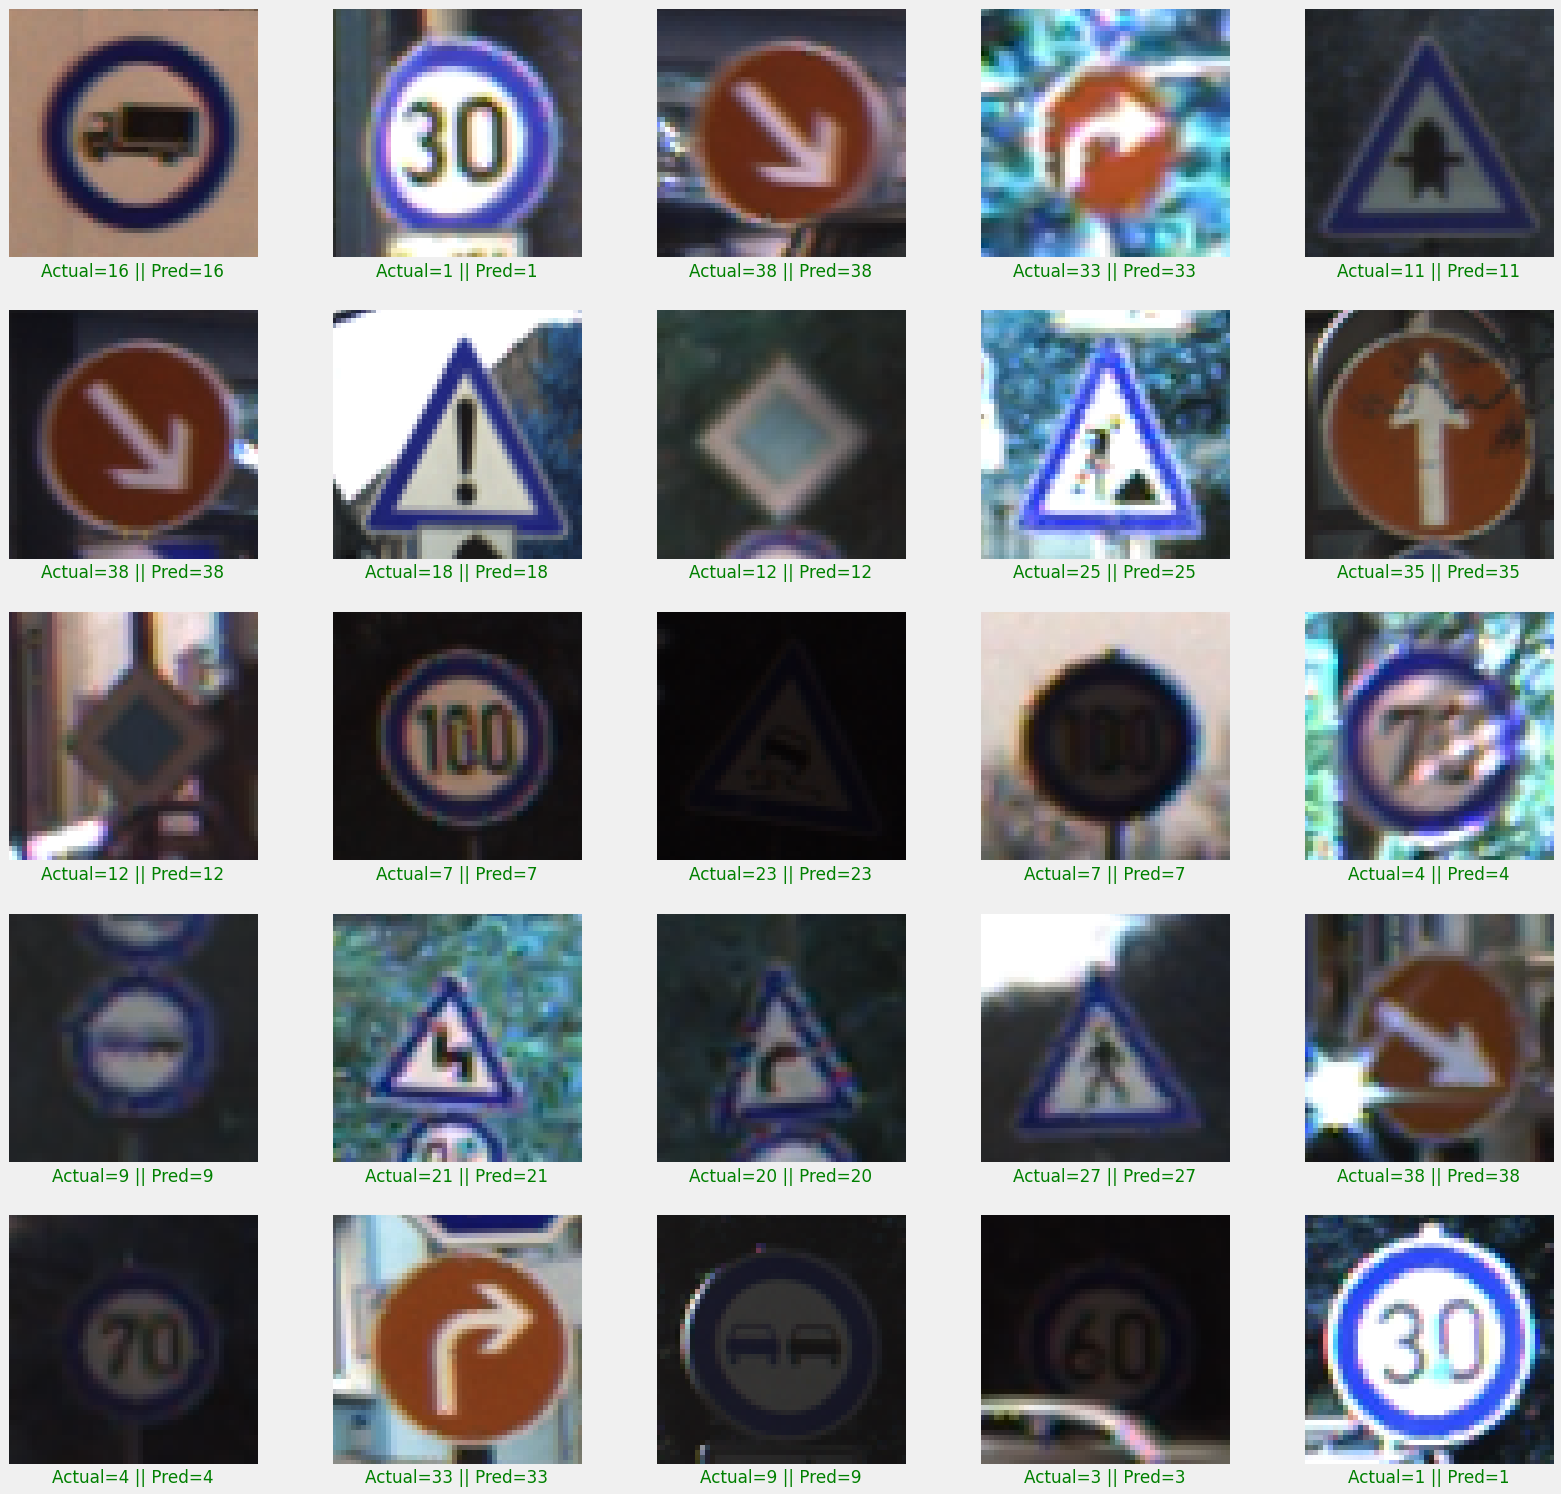

In [38]:
#test of our classifier model
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [39]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


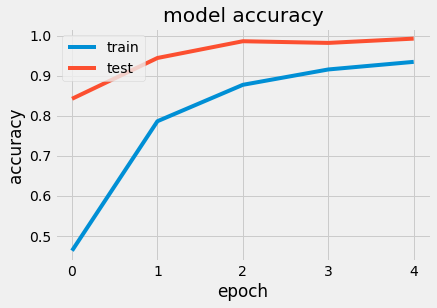

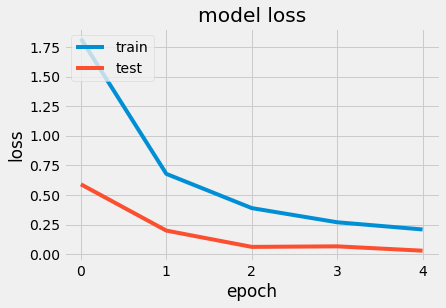

In [40]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()